## Predicting ratings from comments: beware unequal sample frequencies
### 2018 board game comment sentiment analysis session
#### John Burt<br/>Portland Data Science Group <br/>Applied Data Science Meetup series


<img src="machine_learning.png" width="350" style="float: right">

#### Overview: 

- Train a multinomial Naive-Bayes classifier to predict the 1-10 rating for a board game based on a text comment.
- Explore how the unequal distribution of ratings in the training dataset impacts classifier performance.

#### The issue:

Designing a classifier to estimate ratings based on comment text is a common real-world Natural Language Processing (NLP) application. An issue not often discussed is that many training datasets contain unequal numbers of examples of each output category. For example, in the full BGG comment dataset used for this session, there are 248434 examples of comments for games rated 8, but only 4043 examples of 1-rated game comments. 

As a result of this, if trained on such unbalanced frequencies, many classifiers will simply learn to estimate every comment as belonging to the most frequent output category (8). A "rate every game 8" solution will give reasonable looking results **on average** but, of course it does nothing to help you identify better or worse than 8-rated games!

The thing is, if you don't take a closer look at what your model is doing, you may never know that your "good enough" classifier actually totally sucks.

#### The solution:

First, and most obvious, though not always so easy in practice: check your results carefully! Don't rely on an RMSE score for the whole test set to conclude that your solution is working. Look at classifier performance for each category and/or over the range of input and output data. More likely than not you'll find problems on the first pass.

In the case of unequal sample frequencies of output categories, sample balancing is a common way to resolve this: when training your model, give it an equal number of examples of each output category. 

In this notebook, I will explore the effect of balancing on classifier results.

#### About the methods used here:

I'm using the MultinomialNB classifier beause it's a good fit for the problem, but also it's straightforward to implement. I've tried other classifiers and more extensive text processing, and they all show the same effects I demonstrate here.

#### Refs:

I found this article helpful "[Predicting Yelp Stars from Reviews with scikit-learn and Python](http://www.developintelligence.com/blog/2017/03/predicting-yelp-star-ratings-review-text-python/)"

#### Set up notebook environment

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np


#### Load the comment data, prep it for training

In [2]:
# load the comments
data = pd.read_csv('boardgame-comments-english.csv')

# rename the userID column
data = data.rename(columns = {"Compiled from boardgamegeek.com by Matt Borthwick":'userID'})

# round out ratings to integers - these will be used as classifier target categories
data['rating_int'] = np.round(data.rating)

# make sure everything is in proper 1-10 range
data.rating_int[data.rating_int<1] = 1
data.rating_int[data.rating_int>10] = 10


In [3]:
# have a look at the data
data.head()

,userID,gameID,rating,comment,rating_int
0,172640,24068,7.0,Good: Unique take on the hidden role games. T...,7.0
1,86674,24068,7.0,A neat social deduction game with multiple tea...,7.0
2,10643,24068,7.0,Good hidden roles werewolf style game that can...,7.0
3,31171,24068,7.0,"Overall I hate Mafia/Werewolf, but this versio...",7.0
4,165608,24068,7.0,Fun social deduction exercise that gets merrie...,7.0


### Comment frequencies for each rating level

You can see from the histogram below that the majority of comments have ratings between 6-8, with 8-ratings being most by far. Low rated comments, particularly 1-3, are much fewer than higher rated.

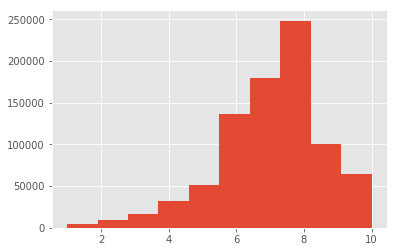

In [4]:
data.rating_int.hist();

## First try: train and test with original unbalanced data

#### Our classifier will be a multinomial Naive Bayes

See here for more: [Naive Bayes classifier for multinomial models](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)



### Convert comment words to weighted count vectors

The Naive Bayes classifier needs vectorized data as input.

scikit learn's [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is an all-in-one tool for this:
- Removes stop words
- Count-vectorizes the words
- Weights each word vector based on the Term Frequency Inverse Document Frequency (TF-IDF) algorithm

Note 1: Usually before this step there is some text cleanup, such as stemming and removal of punctuation, capitalization, etc, but I've left that out in this example for simplicity (it doesn't improve these results that much anyway).

Note 2: You must vectorize all train/test data together, and then partition train/test sets, otherwise the vectors will be different and the classifier won't know that to do with them.

Note 3: X, the vectorized output, will be a numpy sparse matrix and we can't use pandas with it.

Note 4: This step might take some time to run...

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# define model defaults for TF-IDF vectorizer.
tfidfargs = {
    "analyzer":'word', 
    "max_features" : None,
    "max_df" : 0.25, # Filters out terms that occur in more than half of the docs (max_df=0.5)
    "min_df" : 2, # Filters out terms that occur in only one document (min_df=2).
    "ngram_range":(1, 3), # unigrams
    "stop_words" : "english", # None, # "english", # Strips out “stop words”
    "use_idf" : True
    }

# create the vectorizer 
vectorizer = TfidfVectorizer(**tfidfargs)

# Transform the comment text into vectorized data.
X_all = vectorizer.fit_transform(data.comment)

# our target output: a 1-10 integer rating
y_all = data.rating_int

#### Create train / test split data

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(673316, 2238676) (168329, 2238676) (673316,) (168329,)


#### Function to calculate RMSE

In [70]:
from math import sqrt
from statistics import median

def calc_RMSE(diffs):
    diffs = tuple(diffs)
    n = len(diffs)
    ad = tuple(abs(diff) for diff in diffs)
    rmse = sqrt(sum(v*v for v in diffs) / n)
    return rmse      


### Train the classifier with unbalanced data

In [80]:
from sklearn.naive_bayes import MultinomialNB

# create the classifier
clf = MultinomialNB()

# train with unbalanced data
clf.fit(X_train, y_train)

# model score
print('Score = %1.3f'%(clf.score(X_test, y_test)))

# Get predicted ratings
y_pred = clf.predict(X_test)

# report RMSE
print('RMSE = %1.3f'%(calc_RMSE(y_test-y_pred)))

Score = 0.308
RMSE = 1.809


### Let's see how the unbalanced-trained model performed at each rating level

I'll plot a confusion matrix, which shows the proportion of predicted ratings vs the actual ratings. If the classifier properly predicting ratings (predicted rating = actual rating), then only cells along the diagonal will be light (i.e., larger values).

In [81]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y, y_pred, title):

    # rating levels
    ratings = list(range(1,11))

    # generate confusion matrix
    cm = confusion_matrix(y, y_pred)

    # normalize matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plot matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.magma)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(ratings))
    plt.xticks(tick_marks, ratings, rotation=45)
    plt.yticks(tick_marks, ratings)
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Actual rating')
    plt.xlabel('Predicted rating');

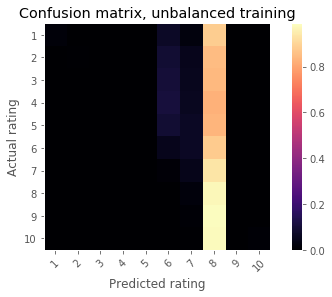

In [82]:
# plot the confusion matrix
plot_confusion(y_test, y_pred, 'Confusion matrix, unbalanced training')

### Result:  
- Nearly every test sample, regardless of actual rating, is rated 8. 


### Conclusion:  This classifier sucks!



=====================================================================================


## Second Try: balanced frequencies of each rating level in training set


### Function to balance data:

This function creates a new dataset with the same number of samples for every rating level. The number of samples for each rating is determined by the rating level with the least number of samples (in this case, 1-ratings). Rating levels with more samples are randomly sub-sampled. Then the function shuffles the entire set.

In [49]:
from scipy.sparse import vstack

# version for separated X and y arrays, X is vectorized text 
def balance_data_vec(X, y):
    minsamples = y.shape[0]
    ratings = list(range(1,11))

    # get min number of samples per rating level: 
    #   we'll use this as our sample size for every rating level.
    for rating in ratings:
        sampsize = (y==rating).sum()
        if sampsize < minsamples:
            minsamples = sampsize

    # take same number of samples for each rating level.
    # sample randomly, create a new dataframe with all samples
    X_bal = []
    y_bal = []
    for rating in ratings:
        X_r = X[y==rating,:]
        y_r = y[y==rating]
        idx = list(range(X_r.shape[0]))
        np.random.shuffle( idx )
        
        # create the output arrays
        if type(X_bal) == list: 
            X_bal = X_r[idx[:minsamples],:]
            y_bal = np.array([rating]*minsamples)
            
        # add samples to output arrays
        else:
            X_bal = vstack((X_bal, X_r[idx[:minsamples],:]))
            y_bal = np.append(y_bal, np.array([rating]*minsamples), axis=0 )
            
    # shuffle all samples
    idx = list(range(X_bal.shape[0])) 
    np.random.shuffle( idx )
    X_bal = X_bal[idx,:]
    y_bal = y_bal[idx]
    
    return X_bal, pd.Series(y_bal)

### Create a new train / test split with the balanced data

In [83]:
X_bal, y_bal = balance_data_vec(X_all, y_all.values)

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal)

print(X_train_bal.shape, X_test_bal.shape, y_train_bal.shape, y_test_bal.shape)


(32344, 2238676) (8086, 2238676) (32344,) (8086,)


### Train the classifier with the balanced training data

In [84]:
# create the classifier
clf_bal = MultinomialNB()

# train with all data
clf_bal.fit(X_train_bal, y_train_bal)

# model score
print('Score = %1.3f'%(clf_bal.score(X_test_bal, y_test_bal)))

# report RMSE
y_pred_bal = clf_bal.predict(X_test_bal)

print('RMSE = %1.3f'%(calc_RMSE(y_test_bal - y_pred_bal)))


Score = 0.264
RMSE = 2.497


### Let's see how the balanced model performed at each rating level

Looking at a confusion matrix again, remember: if the classifier is properly predicting ratings (predicted rating = actual rating), then mostly cells along the diagonal will be light (i.e., have larger values).

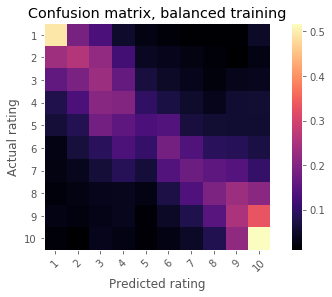

In [85]:
# plot the confusion matrix
plot_confusion(y_test_bal, y_pred_bal, 'Confusion matrix, balanced training')

### Result:  

- Predicted ratings are close to actual ratings, meaning they lie mostly along the diagonal of the confusion matrix. 

- Extreme ratings, 1 and 10, have the best prediction accuracy, while mid-ratings are lowest. This is probably because comments for mid-ratings are more ambiguous than extreme rating comments.


### Conclusion:  This classifier works a lot better!

### Next steps:

- Try out some text cleanup and pre-processing methods, such as stemming.
- Try different classifiers.
- Tune the vectorizer and classifier parameters using GridsearchCV.
